# Child Mind Institute — Problematic Internet Use



## Team notes & log



🔔 <b>REMINDER:</b> Make sure to use GitHub pull before starting work and push when finishing.



<u><b>To Do</b></u>



- Go back and review data, more feature engineering needed

- Optimize model

- Try different models (using pipelines)?

- AG: Visualization



<u><b>Worklog</b></u>



- CP 11/3: Cleaned up some repetitve sections.

- CP 11/5: Merged notebooks with AG & CP's work.

- AG 11/7: Drop unnecessary columns. Dropped a few of them.

- CP 11/11: Filled missing values using KNN, started training the model using Random Forest, calculated scores.

- CP 11/17: Fixed Kaggle submission errors. Imported parquet data. Did some feature engineering. Worked on training the model. Fix error of predictions giving all 0s.



<u><b>Submissions and Results</b></u>



- CP 11/17: Random Forest test submission: 0

- CP 11/17: Random Forest submission 1 (Version 13): 0.012


## Preprocessing


### CSV Data


In [1]:
# Import libraries



# CP

import numpy as np

import pandas as pd

from concurrent.futures import ThreadPoolExecutor

import os

from tqdm import tqdm



#### AG 11/2/24 ###

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [2]:
# CP: The following code is from Kaggle notebook:

# https://www.kaggle.com/code/cchangyyy/0-490-notebook



# Processes a parquet file





def process_file(filename, dirname):

    df = pd.read_parquet(os.path.join(dirname, filename, "part-0.parquet"))

    df.drop("step", axis=1, inplace=True)

    return df.describe().values.reshape(-1), filename.split("=")[1]





def load_time_series(dirname) -> pd.DataFrame:

    ids = os.listdir(dirname)



    with ThreadPoolExecutor() as executor:

        results = list(

            tqdm(

                executor.map(lambda fname: process_file(fname, dirname), ids),

                total=len(ids),

            )

        )



    stats, indexes = zip(*results)



    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])

    df["id"] = indexes

    return df

In [3]:
# CP: Load data

# CP: Check if you are running in Kaggle or locally

# CP: Running locally

if os.path.exists("kaggle_data"):

    train = pd.read_csv("kaggle_data/train.csv")

    test = pd.read_csv("kaggle_data/test.csv")

    data_dict = pd.read_csv("kaggle_data/data_dictionary.csv")

    train_ts = load_time_series("kaggle_data/series_train.parquet")

    test_ts = load_time_series("kaggle_data/series_test.parquet")



# CP: Running in Kaggle

else:

    train = pd.read_csv(

        "/kaggle/input/child-mind-institute-problematic-internet-use/train.csv"

    )

    test = pd.read_csv(

        "/kaggle/input/child-mind-institute-problematic-internet-use/test.csv"

    )

    data_dict = pd.read_csv(

        "/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv"

    )

    train_ts = load_time_series(

        "/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet"

    )

    test_ts = load_time_series(

        "/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet"

    )



# CP: Show all rows when displaying data

pd.set_option("display.max_rows", None)



# CP: Display data dictionary

data_dict

100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
5,Children's Global Assessment Scale,CGAS-CGAS_Score,Children's Global Assessment Scale Score,int,NaN,NaN
6,Physical Measures,Physical-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
7,Physical Measures,Physical-BMI,Body Mass Index (kg/m^2),float,NaN,NaN
8,Physical Measures,Physical-Height,Height (in),float,NaN,NaN
9,Physical Measures,Physical-Weight,Weight (lbs),float,NaN,NaN


In [4]:
# CP: The following code is from Kaggle notebook:

# https://www.kaggle.com/code/cchangyyy/0-490-notebook



time_series_cols = train_ts.columns.tolist()

time_series_cols.remove("id")



train = pd.merge(train, train_ts, how="left", on="id")

test = pd.merge(test, test_ts, how="left", on="id")



train = train.drop("id", axis=1)

# test = test.drop("id", axis=1)

In [5]:
train.shape, test.shape

((3960, 177), (20, 155))

In [6]:
test["id"]

0     00008ff9
1     000fd460
2     00105258
3     00115b9f
4     0016bb22
5     001f3379
6     0038ba98
7     0068a485
8     0069fbed
9     0083e397
10    0087dd65
11    00abe655
12    00ae59c9
13    00af6387
14    00bd4359
15    00c0cd71
16    00d56d4b
17    00d9913d
18    00e6167c
19    00ebc35d
Name: id, dtype: object

In [7]:
# Check which columns are missing in the test set





def missing_columns(df1, df2):

    df1_columns = df1.columns

    df2_columns = df2.columns

    missing_columns = set(df1_columns) - set(df2_columns)

    return missing_columns





missing_columns(train, test)

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [8]:
missing_columns(test, train)

{'id'}

In [9]:
# Shows columns starting with PCIAT-PCIAT

train.filter(like="PCIAT-PCIAT").head()

,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,PCIAT-PCIAT_10,...,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total
0,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0,55.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,28.0
3,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,2.0,...,0.0,3.0,0.0,0.0,3.0,4.0,3.0,4.0,1.0,44.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train.filter(like="PCIAT-PCIAT").isnull().sum()

PCIAT-PCIAT_01       1227
PCIAT-PCIAT_02       1226
PCIAT-PCIAT_03       1229
PCIAT-PCIAT_04       1229
PCIAT-PCIAT_05       1231
PCIAT-PCIAT_06       1228
PCIAT-PCIAT_07       1231
PCIAT-PCIAT_08       1230
PCIAT-PCIAT_09       1230
PCIAT-PCIAT_10       1227
PCIAT-PCIAT_11       1226
PCIAT-PCIAT_12       1229
PCIAT-PCIAT_13       1231
PCIAT-PCIAT_14       1228
PCIAT-PCIAT_15       1230
PCIAT-PCIAT_16       1232
PCIAT-PCIAT_17       1235
PCIAT-PCIAT_18       1232
PCIAT-PCIAT_19       1230
PCIAT-PCIAT_20       1227
PCIAT-PCIAT_Total    1224
dtype: int64

In [11]:
# Drop if all PCIAT-PCIAT columns are null

train = train.dropna(subset=train.filter(like="PCIAT-PCIAT").columns, how="all")

In [12]:
train.filter(like="PCIAT-PCIAT").isnull().sum()

PCIAT-PCIAT_01        3
PCIAT-PCIAT_02        2
PCIAT-PCIAT_03        5
PCIAT-PCIAT_04        5
PCIAT-PCIAT_05        7
PCIAT-PCIAT_06        4
PCIAT-PCIAT_07        7
PCIAT-PCIAT_08        6
PCIAT-PCIAT_09        6
PCIAT-PCIAT_10        3
PCIAT-PCIAT_11        2
PCIAT-PCIAT_12        5
PCIAT-PCIAT_13        7
PCIAT-PCIAT_14        4
PCIAT-PCIAT_15        6
PCIAT-PCIAT_16        8
PCIAT-PCIAT_17       11
PCIAT-PCIAT_18        8
PCIAT-PCIAT_19        6
PCIAT-PCIAT_20        3
PCIAT-PCIAT_Total     0
dtype: int64

In [13]:
# Create a PCIAT-PCIAT_Total column with totals of PCIAT columns

train["PCIAT-PCIAT_Total_Calc"] = train[

    [

        "PCIAT-PCIAT_01",

        "PCIAT-PCIAT_02",

        "PCIAT-PCIAT_03",

        "PCIAT-PCIAT_04",

        "PCIAT-PCIAT_05",

        "PCIAT-PCIAT_06",

        "PCIAT-PCIAT_07",

        "PCIAT-PCIAT_08",

        "PCIAT-PCIAT_09",

        "PCIAT-PCIAT_10",

        "PCIAT-PCIAT_11",

        "PCIAT-PCIAT_12",

        "PCIAT-PCIAT_13",

        "PCIAT-PCIAT_14",

        "PCIAT-PCIAT_15",

        "PCIAT-PCIAT_16",

        "PCIAT-PCIAT_17",

        "PCIAT-PCIAT_18",

        "PCIAT-PCIAT_19",

        "PCIAT-PCIAT_20",

    ]

].sum(axis=1)

In [14]:
# Display columns PCIAT-PCIAT_Total_Calc and PCIAT-PCIAT_Total only if they do not match

train[["PCIAT-PCIAT_Total_Calc", "PCIAT-PCIAT_Total"]][

    train["PCIAT-PCIAT_Total_Calc"] != train["PCIAT-PCIAT_Total"]

]

,PCIAT-PCIAT_Total_Calc,PCIAT-PCIAT_Total


In [15]:
# Drop PCIAT-PCIAT_01 to PCIAT-PCIAT_20 columns

train.drop(

    columns=[

        "PCIAT-PCIAT_01",

        "PCIAT-PCIAT_02",

        "PCIAT-PCIAT_03",

        "PCIAT-PCIAT_04",

        "PCIAT-PCIAT_05",

        "PCIAT-PCIAT_06",

        "PCIAT-PCIAT_07",

        "PCIAT-PCIAT_08",

        "PCIAT-PCIAT_09",

        "PCIAT-PCIAT_10",

        "PCIAT-PCIAT_11",

        "PCIAT-PCIAT_12",

        "PCIAT-PCIAT_13",

        "PCIAT-PCIAT_14",

        "PCIAT-PCIAT_15",

        "PCIAT-PCIAT_16",

        "PCIAT-PCIAT_17",

        "PCIAT-PCIAT_18",

        "PCIAT-PCIAT_19",

        "PCIAT-PCIAT_20",

        "PCIAT-PCIAT_Total",

    ],

    inplace=True,

)

In [16]:
# Check which columns are missing in the test set

missing_columns(train, test)

{'PCIAT-PCIAT_Total_Calc', 'PCIAT-Season', 'sii'}

In [17]:
# Drop PCIAT-Season from train

train.drop(columns=["PCIAT-Season"], inplace=True)

In [18]:
# Add PCIAT-PCIAT_Total_Calc column to test set, fill with null values

test["PCIAT-PCIAT_Total_Calc"] = np.nan

In [19]:
# Check which columns are missing in the test set

missing_columns(train, test)

{'sii'}

In [20]:
train.shape, test.shape

((2736, 156), (20, 156))

In [21]:
#### AG 11/2/24 ###

train.head(20)

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,PCIAT-PCIAT_Total_Calc
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,NaN,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,44.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,NaN,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,34.0
6,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
11,Fall,11,0,Summer,66.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
12,Fall,13,0,NaN,NaN,Winter,21.079065,57.75,100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0
15,Winter,7,0,Summer,51.0,Spring,29.315775,54.00,121.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0
16,Spring,5,1,Summer,80.0,Spring,17.284504,44.00,47.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [22]:
# There are null values in every column except for "age" , "sex", and "basic season"

# sii: Severity Impairment Index: Range (0-3)

train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,2736.0,1.023867e+01,3.427982e+00,5.000000e+00,8.000000e+00,1.000000e+01,1.200000e+01,2.200000e+01
Basic_Demos-Sex,2736.0,3.644006e-01,4.813496e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
CGAS-CGAS_Score,2342.0,6.515927e+01,1.181105e+01,2.500000e+01,5.900000e+01,6.500000e+01,7.500000e+01,9.500000e+01
Physical-BMI,2527.0,1.912567e+01,4.909305e+00,0.000000e+00,1.577345e+01,1.781901e+01,2.117231e+01,4.610291e+01
Physical-Height,2530.0,5.589705e+01,7.394938e+00,3.600000e+01,5.005000e+01,5.500000e+01,6.175000e+01,7.850000e+01
Physical-Weight,2572.0,8.783959e+01,4.335308e+01,0.000000e+00,5.720000e+01,7.580000e+01,1.114500e+02,3.150000e+02
Physical-Waist_Circumference,483.0,2.662526e+01,5.230213e+00,1.900000e+01,2.300000e+01,2.600000e+01,2.900000e+01,5.000000e+01
Physical-Diastolic_BP,2478.0,6.975504e+01,1.379020e+01,1.100000e+01,6.100000e+01,6.800000e+01,7.600000e+01,1.790000e+02
Physical-HeartRate,2486.0,8.182341e+01,1.376982e+01,2.700000e+01,7.300000e+01,8.100000e+01,9.100000e+01,1.380000e+02
Physical-Systolic_BP,2478.0,1.171279e+02,1.722171e+01,4.900000e+01,1.070000e+02,1.140000e+02,1.250000e+02,2.030000e+02


In [23]:
####AG###



#### Notes ####



## Children Global Assessment Scale(CGAS) score is used to check the general

# functioning level of children typically in the range of 1-100

# CGAS score has max value 999 which might be an outlier.



##PCIAT-PCIAT_Total = Parent-Child Internet Addiction Test

# the score reflects addiction or PIU, which might be 0 if no problematic behavior is found

##SDS-SDS_Total_Raw: Self-Rating Depression , raw scores can range from: 20-80

# min for this is 38 in the table which means even lowest

# scoring children may be experiencing mild depressive symptoms

##PreInt_EduHx-computerinternet_hoursday : avg number of hours per day spent using internet

In [24]:
####AG###



## Report of the extensive missing values ##



# Fitness_Endurance-Max_Stage: 743 non-null (81% missing)

# Fitness_Endurance-Time_Mins: 740 non-null (81% missing)

# Fitness_Endurance-Time_Sec: 740 non-null (81% missing)

# Physical-Waist_Circumference: 898 non-null (77% missing)

# BIA-Activity_Level_num: 1991 non-null (50% missing)

# BIA-BMC: 1991 non-null (50% missing)

# BIA-BMI: 1991 non-null (50% missing)

# BIA-BMR: 1991 non-null (50% missing)

# BIA-DEE: 1991 non-null (50% missing)

# BIA-ECW: 1991 non-null (50% missing)

# PAQ_A-Season: 475 non-null (88% missing)

# PAQ_A-PAQ_A_Total: 475 non-null (88% missing)

# PAQ_C-Season: 1721 non-null (57% missing)

# PAQ_C-PAQ_C_Total: 1721 non-null (57% missing)

# PCIAT-Season: 2736 non-null (31% missing) with multiple related PCIAT columns also having missing data.

# SDS-Season: 2618 non-null (34% missing)

# SDS-SDS_Total_Raw: 2609 non-null (35% missing)

# SDS-SDS_Total_T: 2606 non-null (35% missing)



# CP: Check for missing/null values

train.isnull().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                                394
CGAS-CGAS_Score                            394
Physical-Season                            141
Physical-BMI                               209
Physical-Height                            206
Physical-Weight                            164
Physical-Waist_Circumference              2253
Physical-Diastolic_BP                      258
Physical-HeartRate                         250
Physical-Systolic_BP                       258
Fitness_Endurance-Season                  1476
Fitness_Endurance-Max_Stage               2005
Fitness_Endurance-Time_Mins               2008
Fitness_Endurance-Time_Sec                2008
FGC-Season                                  89
FGC-FGC_CU                                 817
FGC-FGC_CU_Zone                            852
FGC-FGC_GSND                              1864
FGC-FGC_GSND_

In [25]:
# CP: Explore data

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Columns: 156 entries, Basic_Demos-Enroll_Season to PCIAT-PCIAT_Total_Calc
dtypes: float64(144), int64(2), object(10)
memory usage: 3.3+ MB


In [26]:
# CP: Explore data

train.shape

(2736, 156)

In [27]:
# CP: Check target values

train["sii"].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [28]:
# CP: Check missing target values

train["sii"].isnull().sum()

0

In [29]:
# CP: Drop any rows where target value is missing

# since they cannot be used for training.

train.dropna(subset=["sii"], inplace=True)

In [30]:
# CP: Recheck missing target values

train["sii"].isnull().sum()

0

In [31]:
# CP: Check for duplicates

train.duplicated().sum()

0

In [32]:
train.shape

(2736, 156)

In [33]:
# 11/7/24 AG ###

# checking columns with more than 50% of the data missing

# CP: Adjusted to 64% due to parquet data

missing_percentage = train.isnull().mean() * 100

columns_with_missing_data = missing_percentage[missing_percentage > 64]

columns_with_missing_data

Physical-Waist_Circumference    82.346491
Fitness_Endurance-Max_Stage     73.282164
Fitness_Endurance-Time_Mins     73.391813
Fitness_Endurance-Time_Sec      73.391813
FGC-FGC_GSND                    68.128655
FGC-FGC_GSND_Zone               68.421053
FGC-FGC_GSD                     68.165205
FGC-FGC_GSD_Zone                68.421053
PAQ_A-Season                    86.732456
PAQ_A-PAQ_A_Total               86.732456
dtype: float64

In [34]:
# Checking the correlation of the numeric columns with sii

numerical_columns = train.select_dtypes(include=["float64", "int64"]).columns



# No sii in  the numerical columns to avoid correlating it with itself

numerical_columns = numerical_columns[numerical_columns != "sii"]

correlation = train[numerical_columns].corrwith(train["sii"])



correlation

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Basic_Demos-Age                           0.365990
Basic_Demos-Sex                          -0.100148
CGAS-CGAS_Score                          -0.085261
Physical-BMI                              0.221125
Physical-Height                           0.373530
Physical-Weight                           0.325938
Physical-Waist_Circumference              0.272885
Physical-Diastolic_BP                     0.050971
Physical-HeartRate                       -0.024572
Physical-Systolic_BP                      0.135336
Fitness_Endurance-Max_Stage              -0.070589
Fitness_Endurance-Time_Mins              -0.060628
Fitness_Endurance-Time_Sec                0.008701
FGC-FGC_CU                                0.247364
FGC-FGC_CU_Zone                          -0.023944
FGC-FGC_GSND                              0.149495
FGC-FGC_GSND_Zone                         0.001667
FGC-FGC_GSD                               0.163448
FGC-FGC_GSD_Zone                          0.023696
FGC-FGC_PU                     

In [35]:
train.isnull().sum()

Basic_Demos-Enroll_Season                    0
Basic_Demos-Age                              0
Basic_Demos-Sex                              0
CGAS-Season                                394
CGAS-CGAS_Score                            394
Physical-Season                            141
Physical-BMI                               209
Physical-Height                            206
Physical-Weight                            164
Physical-Waist_Circumference              2253
Physical-Diastolic_BP                      258
Physical-HeartRate                         250
Physical-Systolic_BP                       258
Fitness_Endurance-Season                  1476
Fitness_Endurance-Max_Stage               2005
Fitness_Endurance-Time_Mins               2008
Fitness_Endurance-Time_Sec                2008
FGC-Season                                  89
FGC-FGC_CU                                 817
FGC-FGC_CU_Zone                            852
FGC-FGC_GSND                              1864
FGC-FGC_GSND_

In [36]:
# Check the missing percentage for specific columns

columns_of_interest = [

    "PAQ_A-Season",

    "PAQ_A-PAQ_A_Total",

    "Physical-Waist_Circumference",

    "Fitness_Endurance-Max_Stage",

    "Fitness_Endurance-Time_Mins",

    "Fitness_Endurance-Time_Sec",

]



# percentage of missing values in these columns

missing_percentage = train[columns_of_interest].isnull().mean() * 100

print("Missing percentage:")

print(missing_percentage)



numerical_columns = (

    train[columns_of_interest].select_dtypes(include=["float64", "int64"]).columns

)



# Calculate correlation of the numerical columns with the target variable 'sii'

correlation_with_sii = train[numerical_columns].corrwith(train["sii"])



print("\nCorrelation with sii:")

print(correlation_with_sii)

Missing percentage:
PAQ_A-Season                    86.732456
PAQ_A-PAQ_A_Total               86.732456
Physical-Waist_Circumference    82.346491
Fitness_Endurance-Max_Stage     73.282164
Fitness_Endurance-Time_Mins     73.391813
Fitness_Endurance-Time_Sec      73.391813
dtype: float64

Correlation with sii:
PAQ_A-PAQ_A_Total              -0.050386
Physical-Waist_Circumference    0.272885
Fitness_Endurance-Max_Stage    -0.070589
Fitness_Endurance-Time_Mins    -0.060628
Fitness_Endurance-Time_Sec      0.008701
dtype: float64


In [37]:
# creating a backup

backup_train = train.copy()

In [38]:
# # Dropping columns that have null values more than 50% and weak sii connection

# train.drop(columns=columns_of_interest, inplace=True)

# test.drop(columns=columns_of_interest, inplace=True)

# train.isnull().sum()

In [39]:
# train = train.fillna(0) # replacing null values with 0 for uniformity

In [40]:
# 11/9/24   AG ####



# Further cleaning process ##



# Fitness_Endurance-Season (1,476 missing)

# FGC-FGC_GSND (1,864 missing)

# FGC-FGC_GSND_Zone (1,872 missing)

# FGC-FGC_GSD (1,865 missing)

# FGC-FGC_GSD_Zone (1,872 missing)

# PAQ_C-Season (1,296 missing)

# PAQ_C-PAQ_C_Total (1,296 missing)

In [41]:
from sklearn.preprocessing import LabelEncoder



# Encode categorical features

train["Fitness_Endurance-Season"] = LabelEncoder().fit_transform(

    train["Fitness_Endurance-Season"].astype(str)

)

train["PAQ_C-Season"] = LabelEncoder().fit_transform(train["PAQ_C-Season"].astype(str))



selected_features = [

    "Fitness_Endurance-Season",

    "FGC-FGC_GSND",

    "FGC-FGC_GSND_Zone",

    "FGC-FGC_GSD_Zone",

    "FGC-FGC_GSD",

    "PAQ_C-Season",

    "PAQ_C-PAQ_C_Total",

]



correlation = train[selected_features].corrwith(train["sii"])



print("\nCorrelation with sii:")

print(correlation)


Correlation with sii:
Fitness_Endurance-Season    0.137864
FGC-FGC_GSND                0.149495
FGC-FGC_GSND_Zone           0.001667
FGC-FGC_GSD_Zone            0.023696
FGC-FGC_GSD                 0.163448
PAQ_C-Season               -0.051177
PAQ_C-PAQ_C_Total           0.005665
dtype: float64


In [42]:
# Notes #



# Fitness_Endurance-Season

# Meaning: Measures endurance levels during a specific season (e.g., Fall, Winter).

# Relation to PIU: People who exercise more or have better endurance might spend less time on the internet. However, this feature doesn’t seem to impact PIU much.

# Missing Values: 1,476

# Correlation: -0.097 (weak negative relationship) - so decided to drop it





# FGC-FGC_GSND

# Meaning: Some specific fitness or physical activity score (GSND).

# Relation to PIU: Higher physical fitness might indicate better lifestyle habits and less internet use.

# Missing Values: 1,864

# Correlation: 0.258 (moderate positive relationship)- Keep it



# FGC-FGC_GSND_Zone

# Meaning: A category or performance zone for the GSND score (e.g., low, medium, high).

# Relation to PIU: Similar to FGC-FGC_GSND, categorizing fitness levels may help identify those at risk of PIU.

# Missing Values: 1,872

# Correlation: 0.226 (moderate positive relationship)

# overlap with FGC-FGC_GSND?? Not sure



# FGC-FGC_GSD

# Meaning: Another specific physical fitness score (GSD).

# Relation to PIU: Indicates general fitness levels, which might help reduce internet use.

# Missing Values: 1,865

# Correlation: 0.261 (moderate positive relationship)

# Keeping it



# FGC-FGC_GSD_Zone

# Meaning: Zone or category for GSD (e.g., fitness performance level).

# Relation to PIU: Helps categorize fitness levels and may highlight patterns in PIU.

# Missing Values: 1,872

# Correlation: 0.229 (moderate positive relationship)

# Similar to FGC-FGC_GSD. could overlap?



# PAQ_C-Season

# Meaning: Seasonal data from a physical activity questionnaire (PAQ).

# Relation to PIU: Physical activity might vary with seasons, which could affect internet habits.

# Missing Values: 1,296

# Correlation: 0.085 (weak positive relationship)

#



# PAQ_C-PAQ_C_Total

# Meaning: Total score from the PAQ, summarizing physical activity levels.

# Relation to PIU: Higher physical activity may reduce time spent online, improving lifestyle balance.

# Missing Values: 1,296

# Correlation: 0.076 (weak positive relationship)

# Weak relation to PIU.

In [43]:
columns_to_drop = ["Fitness_Endurance-Season", "PAQ_C-Season", "PAQ_C-PAQ_C_Total"]

train = train.drop(columns=columns_to_drop)

test = test.drop(columns=columns_to_drop)



print(train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Columns: 153 entries, Basic_Demos-Enroll_Season to PCIAT-PCIAT_Total_Calc
dtypes: float64(143), int64(2), object(8)
memory usage: 3.2+ MB
None


In [44]:
# Checking features in  a corr matrix that might have overlap with each other



overlap_features = [

    "FGC-FGC_GSND",

    "FGC-FGC_GSND_Zone",

    "FGC-FGC_GSD",

    "FGC-FGC_GSD_Zone",

]



correlation_matrix = train[overlap_features].corr()

print("Correlation Matrix:")

print(correlation_matrix)

Correlation Matrix:
                   FGC-FGC_GSND  FGC-FGC_GSND_Zone  FGC-FGC_GSD  \
FGC-FGC_GSND           1.000000           0.419748     0.862181   
FGC-FGC_GSND_Zone      0.419748           1.000000     0.352702   
FGC-FGC_GSD            0.862181           0.352702     1.000000   
FGC-FGC_GSD_Zone       0.375547           0.745187     0.464037   

                   FGC-FGC_GSD_Zone  
FGC-FGC_GSND               0.375547  
FGC-FGC_GSND_Zone          0.745187  
FGC-FGC_GSD                0.464037  
FGC-FGC_GSD_Zone           1.000000  


In [45]:
# Can see a high correlation

# FGC-FGC_GSND and FGC-FGC_GSD are providing nearly the same information.

# Similarly, FGC-FGC_GSND_Zone and FGC-FGC_GSD_Zone



# train = train.drop(columns=['FGC-FGC_GSND','FGC-FGC_GSND_Zone'])

In [46]:
train = train.drop(

    columns=[

        "Fitness_Endurance-Max_Stage",

        "Fitness_Endurance-Time_Mins",

        "Fitness_Endurance-Time_Sec",

    ]

)  # had forgotton to drop these attributes with highest null values



test = test.drop(

    columns=[

        "Fitness_Endurance-Max_Stage",

        "Fitness_Endurance-Time_Mins",

        "Fitness_Endurance-Time_Sec",

    ]

)

In [47]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Columns: 150 entries, Basic_Demos-Enroll_Season to PCIAT-PCIAT_Total_Calc
dtypes: float64(140), int64(2), object(8)
memory usage: 3.2+ MB


In [48]:
# train['PAQ_A-Season'].head(50)

train = train.drop(columns=["PAQ_A-Season"])

test = test.drop(columns=["PAQ_A-Season"])

In [49]:
# Working on categorical columnns



categorical_columns = [

    'Basic_Demos-Enroll_Season',

    'CGAS-Season',

    'Physical-Season',

    'FGC-Season',

    'BIA-Season',

    'SDS-Season',

    'PreInt_EduHx-Season'

]

# Replace 0 values with Unknown for categorical attributes

#train[categorical_columns] = train[categorical_columns].replace(0, 'Unknown')



train[categorical_columns].head(50)

,Basic_Demos-Enroll_Season,CGAS-Season,Physical-Season,FGC-Season,BIA-Season,SDS-Season,PreInt_EduHx-Season
0,Fall,Winter,Fall,Fall,Fall,NaN,Fall
1,Summer,NaN,Fall,Fall,Winter,Fall,Summer
2,Summer,Fall,Fall,Fall,NaN,Fall,Summer
3,Winter,Fall,Summer,Summer,Summer,Summer,Winter
5,Spring,Winter,Summer,Summer,Summer,Summer,Spring
6,Fall,NaN,Fall,Fall,Fall,Winter,Fall
11,Fall,Summer,NaN,Winter,NaN,Winter,Fall
12,Fall,NaN,Winter,Winter,Winter,Fall,Fall
15,Winter,Summer,Spring,Spring,NaN,Spring,Winter
16,Spring,Summer,Spring,Spring,NaN,Spring,Spring


In [50]:
# train = train.drop(columns=["id"])

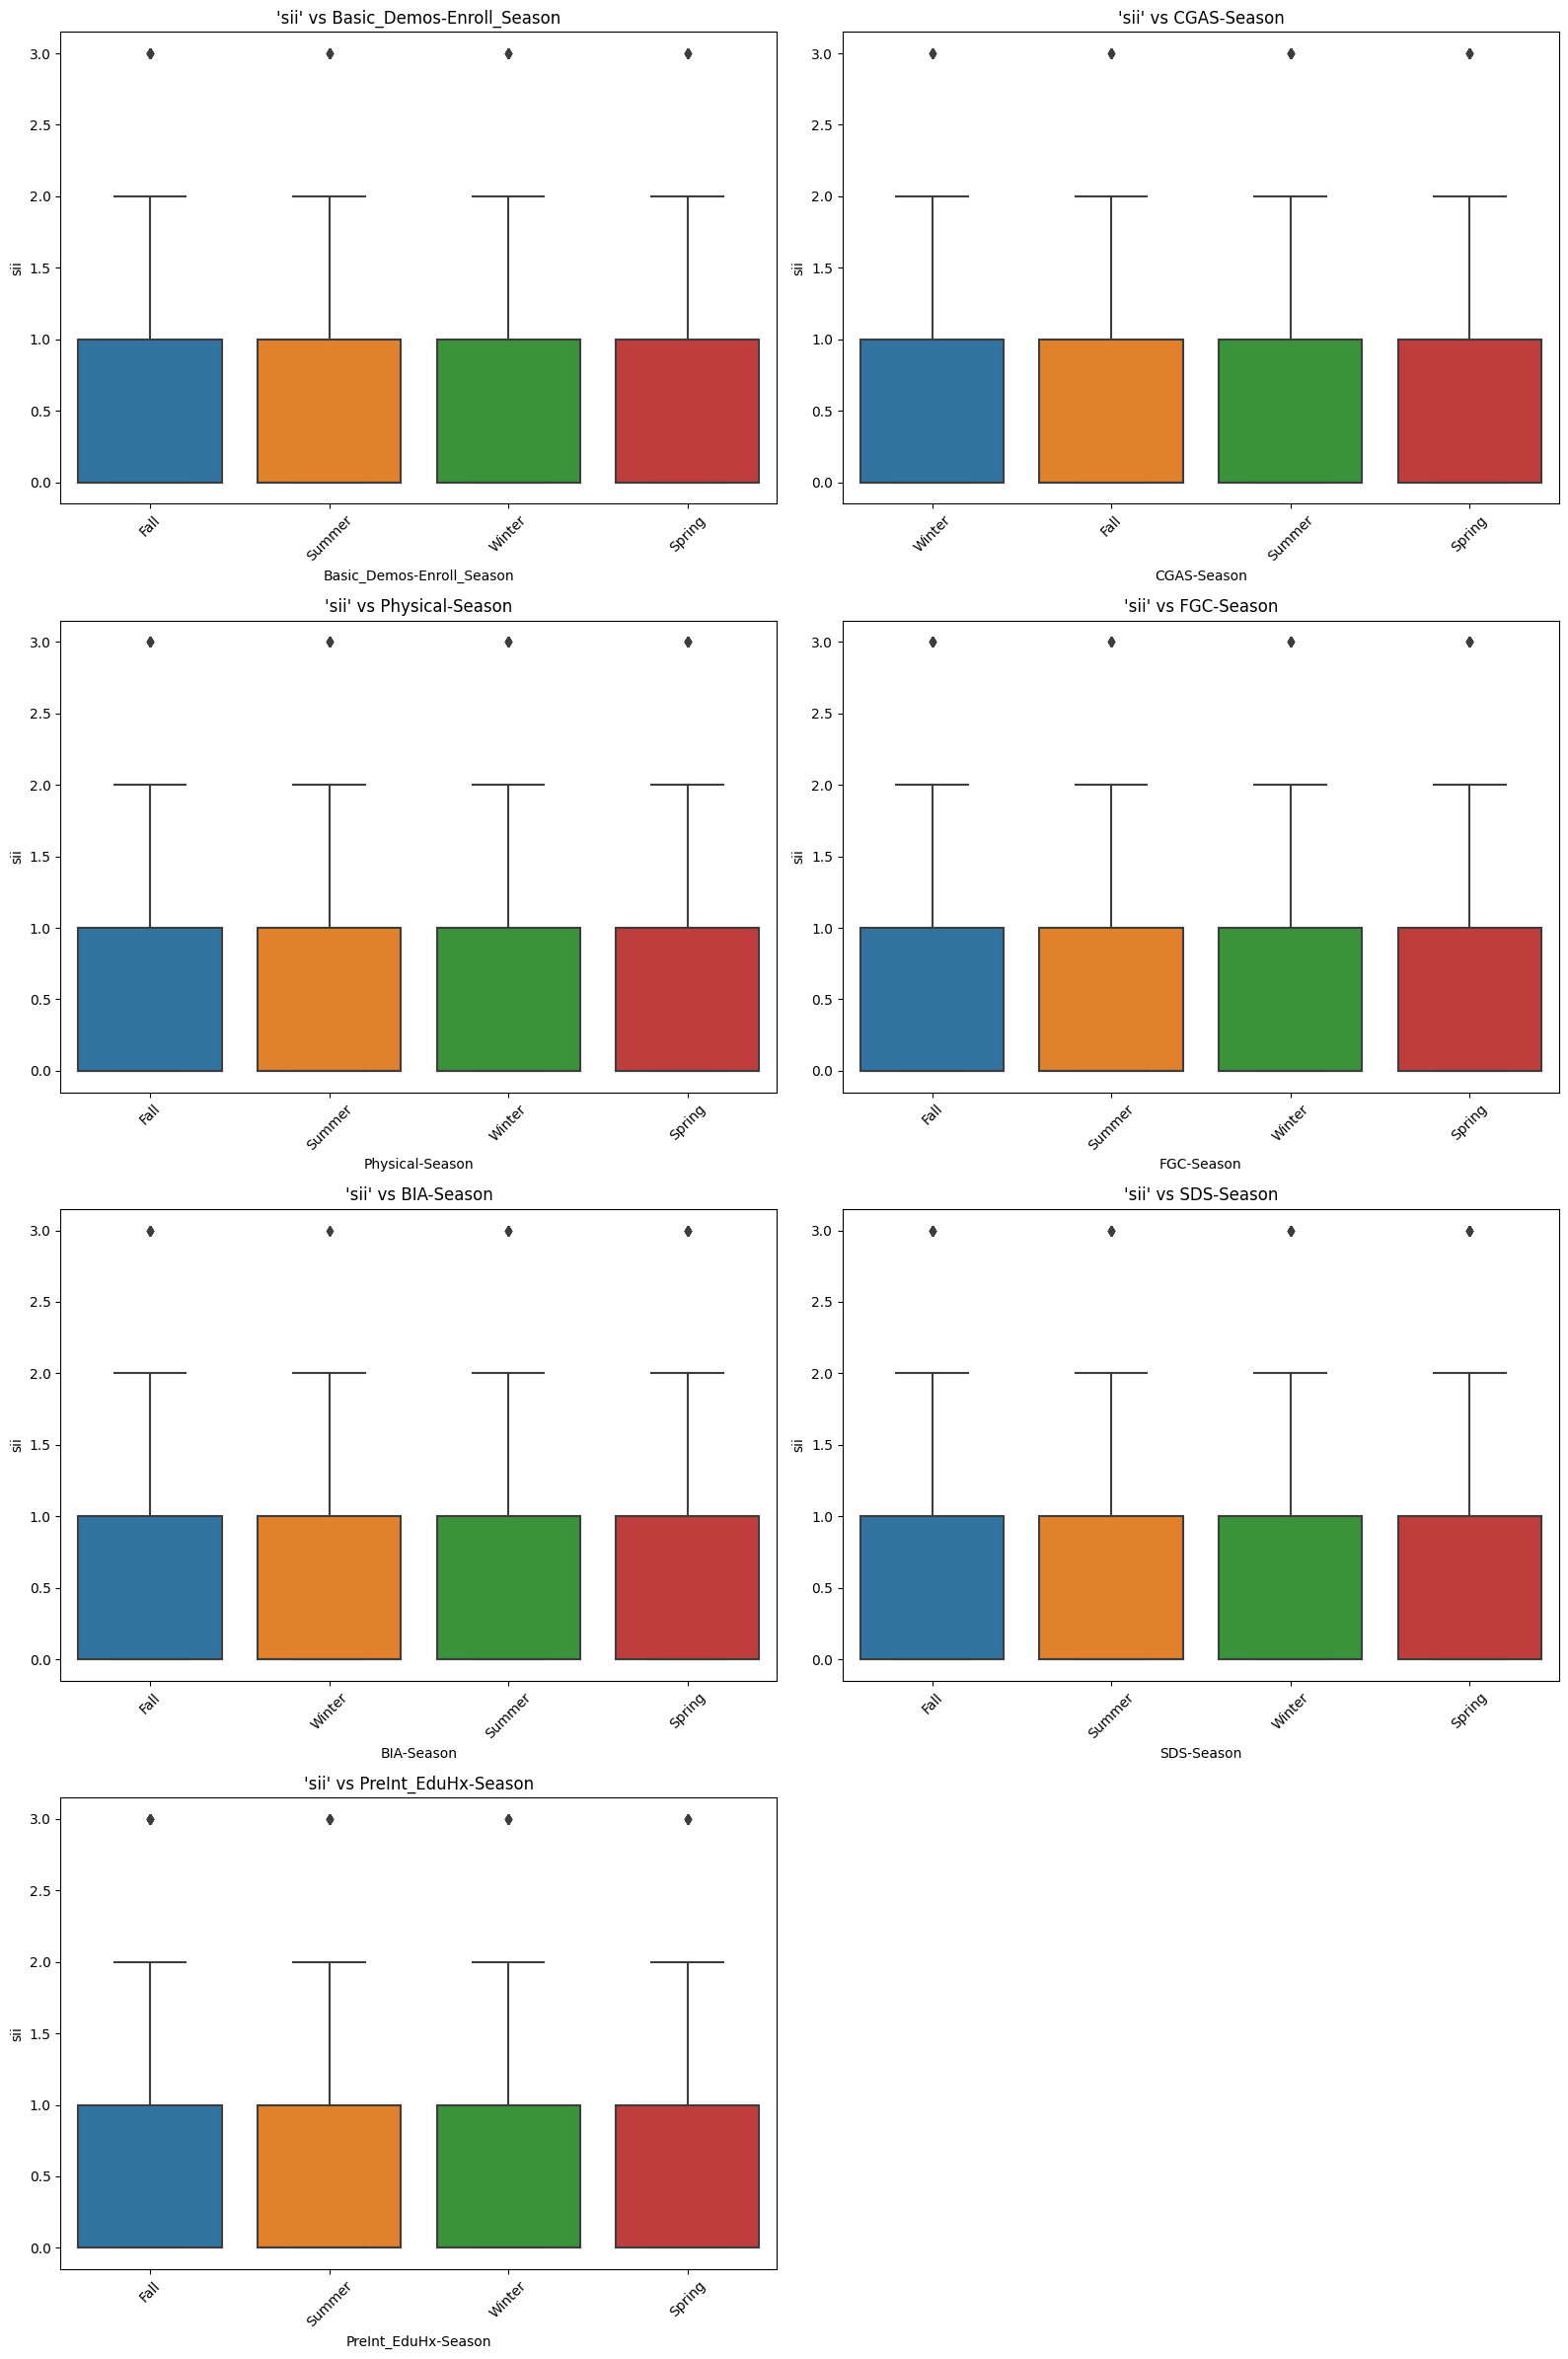

In [51]:
# Plotting boxplots for sii  against each categorical column



plt.figure(figsize=(16, 24))

for i, col in enumerate(categorical_columns, 1):

    plt.subplot(4, 2, i)

    sns.boxplot(x=col, y="sii", data=train)

    plt.xticks(rotation=45)

    plt.title(f"'sii' vs {col}")

plt.tight_layout()

plt.show()

In [52]:
# CP: Drop columns with season data

train = train.drop(columns=train.filter(regex="Season$").columns)

test = test.drop(columns=test.filter(regex="Season$").columns)

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Columns: 142 entries, Basic_Demos-Age to PCIAT-PCIAT_Total_Calc
dtypes: float64(140), int64(2)
memory usage: 3.0 MB


In [53]:
train.head(20)

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,PCIAT-PCIAT_Total_Calc
0,5,0,51.0,16.877316,46.00,50.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
1,9,0,NaN,14.035590,48.00,46.0,22.0,75.0,70.0,122.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,10,1,71.0,16.648696,56.50,75.6,NaN,65.0,94.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
3,9,0,71.0,18.292347,56.00,81.6,NaN,60.0,97.0,117.0,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,44.0
5,13,1,50.0,22.279952,59.50,112.2,NaN,60.0,73.0,102.0,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,34.0
6,10,0,NaN,19.660760,55.00,84.6,NaN,123.0,83.0,163.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0
11,11,0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
12,13,0,NaN,21.079065,57.75,100.0,NaN,63.0,79.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0
15,7,0,51.0,29.315775,54.00,121.6,NaN,80.0,75.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0
16,5,1,80.0,17.284504,44.00,47.6,NaN,61.0,76.0,109.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [54]:
# CP: Fill in missing values using KNN

from sklearn.impute import KNNImputer



imputer = KNNImputer(n_neighbors=5)



train_filled = imputer.fit_transform(train)

train = pd.DataFrame(train_filled, columns=train.columns)



train.isnull().sum().sum()

0

In [55]:
# CP: Fill in missing values using KNN for test data

test_backup = test.copy()



# Add a placeholder 'sii' column to the test data

test['sii'] = np.nan



# Reindex the test dataframe to match the training dataframe

test = test.reindex(columns=train.columns, fill_value=0)



# Drop the 'id' column

# test = test.drop(columns=['id'])



test_filled = imputer.transform(test)

test = pd.DataFrame(test_filled, columns=test.columns)



# Drop the placeholder 'sii' column after imputation

test = test.drop(columns=['sii'])

In [56]:
train.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,PCIAT-PCIAT_Total_Calc
0,5.0,0.0,51.0,16.877316,46.0,50.8,25.6,66.6,81.6,113.8,...,3.252203,86.678120,0.8,1333.363339,4162.2,8.639500e+13,7.0,2.4,39.0,55.0
1,9.0,0.0,62.8,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,...,3.252203,86.678120,0.8,1333.363339,4162.2,8.639500e+13,7.0,2.4,39.0,0.0
2,10.0,1.0,71.0,16.648696,56.5,75.6,28.2,65.0,94.0,117.0,...,3.252203,86.678120,0.8,1333.363339,4162.2,8.639500e+13,7.0,2.4,39.0,28.0
3,9.0,0.0,71.0,18.292347,56.0,81.6,25.4,60.0,97.0,117.0,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,44.0
4,13.0,1.0,50.0,22.279952,59.5,112.2,25.4,60.0,73.0,102.0,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,34.0


In [57]:
# train.shape, test.shape

In [58]:
# test_backup = test.copy()



# # Ensure the test dataframe has the same columns as the training dataframe

# test_no_id = test.reindex(columns=train.columns, fill_value=0)



# # Apply the imputer to the test dataframe

# test_filled = imputer.transform(test_no_id)

# test = pd.DataFrame(test_filled, columns=test_no_id.columns)

In [59]:
train.shape, test.shape

((2736, 142), (20, 141))

## Training the model



Portions of Random Forest code used from class.


In [60]:
# CP: Import the necessary libraries

from sklearn.metrics import roc_auc_score

In [61]:
# Split the data into training and test sets

X = train.drop('sii', axis=1).copy()

y = train['sii'].copy()

In [62]:
# AG 11/21 

from sklearn.preprocessing import MinMaxScaler

#Scaling the training data. 
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [63]:
# # Number of samples and features

# num_features = X_train.shape[1]

# num_samples = X_train.shape[0]

# num_samples, num_features

In [64]:
# Import libraries

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn import svm



from sklearn.metrics import classification_report

from sklearn import metrics

from sklearn.metrics import f1_score

### Pipelines


In [65]:
# # Used pipelines to compare models and reduce code

# pl_lr = Pipeline([('log_reg', LogisticRegression(solver='liblinear', max_iter=1000))])

# pl_rf = Pipeline([('rf', RandomForestClassifier())])

# pl_gnb = Pipeline([('gnb', GaussianNB())])

# pl_svm = Pipeline([('svm', svm.SVC(kernel='linear'))])



# pipelines = [pl_lr, pl_rf, pl_gnb, pl_svm]

# pipe_dict = {0: 'Logistic Regression', 1: 'Random Forest', 2: 'Naive Bayes', 3: 'SVM'}



# for pipe in pipelines:

#     pipe.fit(X_train, y_train)



# for i, model in enumerate(pipelines):

#     pred_test = model.predict(X_test)

#     print("{} Test F1: {}".format(pipe_dict[i], f1_score(y_test, pred_test)))

#     print(classification_report(y_test, pred_test))

#     metrics.confusion_matrix(y_test, pred_test)


### Model training: Random Forest


In [66]:
# Although Logistic Regression scored highest above, Random Forest scored higher in Kaggle submission
from sklearn.metrics import accuracy_score, classification_report
rf = RandomForestClassifier(oob_score=True)



rf.fit(X_train, y_train)



pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train) # AG 11/21

#Checking accuracy score 
print('Testing data: Model accuracy score : {0:0.4f}'.format(accuracy_score(y_test, pred_test)*100))
print('Training data: Model accuracy score : {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)*100))

print("Random Forest F1 Score: ", f1_score(y_test, pred_test, average='weighted'))

print(classification_report(y_test, pred_test))


Testing data: Model accuracy score : 96.3504
Training data: Model accuracy score : 100.0000
Random Forest F1 Score:  0.9600325827104675
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       164
         1.0       0.90      1.00      0.95        62
         2.0       0.93      0.84      0.88        44
         3.0       1.00      0.25      0.40         4

    accuracy                           0.96       274
   macro avg       0.96      0.77      0.81       274
weighted avg       0.97      0.96      0.96       274



In [67]:
# # Get feature importances

# columns = X_train.columns



# importances = rf.feature_importances_

# indices = np.argsort(importances)[::-1]



# # Summarize feature importances

# print("Feature ranking:")

# for f in range(X_train.shape[1]):

#     print(f"{f + 1}. feature {columns[indices[f]]} ({importances[indices[f]]:.3f})")



# # Filter features with importance greater than 0

# filtered_indices = [i for i in indices if importances[i] > 0.005]

# filtered_importances = importances[filtered_indices]

# filtered_columns = columns[filtered_indices]



# # Plot the feature importances

# plt.figure()

# plt.title("Feature Importances (Only > 0.005)")

# plt.bar(range(len(filtered_importances)), filtered_importances, color="r", align="center")

# plt.xticks(range(len(filtered_importances)), [filtered_columns[i] for i in range(len(filtered_columns))], rotation=90)

# plt.xlim([-1, len(filtered_importances)])

# plt.show()


Text(0.5, 427.9555555555555, 'Predicted label')

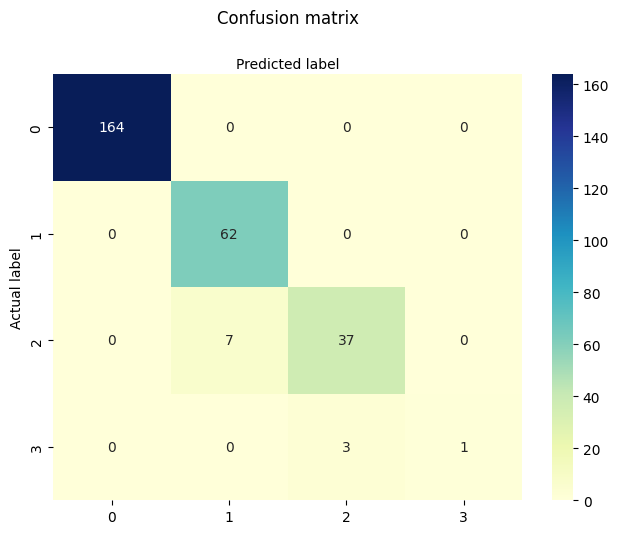

In [68]:
# Plot confusion matrix

class_names=[0,1]

fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)

plt.yticks(tick_marks, class_names)

cnf_matrix = metrics.confusion_matrix(y_test, pred_test)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

ax.xaxis.set_label_position("top")

plt.tight_layout()

plt.title('Confusion matrix', y=1.1)

plt.ylabel('Actual label')

plt.xlabel('Predicted label')

### Prep test data


In [69]:
X_train.shape, test.shape

((2462, 141), (20, 141))

In [70]:
# Make sure train and test match

# missing_columns(X_train, test)

In [71]:
# Make sure train and test match

# missing_columns(test, X_train)

In [72]:
# Drop sii column from test

# test.drop('sii', axis=1, inplace=True)

In [73]:
# X_train.shape, test.shape

In [74]:
# test.columns

In [75]:
# # Drop the 'id' column from the test dataset

# # test_features = test.drop(columns=['id'])

# test_features = test.copy()

# test_features.isnull().sum().sum()

In [76]:
# # Ensure test_features has the same columns as X_train

# test_features = test_features.reindex(columns=X_train.columns, fill_value=0)

# test_features.isnull().sum().sum()

In [77]:
# test_features.shape, X_train.shape

In [78]:
# # Fill in missing values using KNN for test data

# test_filled = imputer.transform(test_features)

# test_features = pd.DataFrame(test_filled, columns=test_features.columns)

In [79]:
# # Predict the sii column for the test dataset

# y_test_pred = rf.predict(test_features)

# y_test_pred

In [80]:
# # Convert y_pred to int

# y_test_pred = y_test_pred.astype(int)

# y_test_pred

In [81]:
# # Export CSV file with predictions

# output = pd.DataFrame({'id': test_backup['id'], 'sii': y_test_pred})

# output.to_csv('submission.csv', index=False)

# print("Submission was successfully saved.")

In [82]:
from sklearn.linear_model import LogisticRegression



LR = LogisticRegression()

LR.fit(X_train, y_train)

y_pred_test = LR.predict(X_test)
y_pred_train = rf.predict(X_train)

print('Testing data accuracy: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)*100))
print('Training data accuracy: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)*100))

Testing data accuracy: 89.7810
Training data accuracy: 100.0000


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [83]:
X = test  
X = scaler.fit_transform(X)
y_pred = LR.predict(X)

submission = pd.DataFrame({
    'id': test_backup['id'],  
    'sii': y_pred.astype(int) 
})


submission.to_csv('submission.csv', index=False)
print(submission)

          id  sii
0   00008ff9    1
1   000fd460    1
2   00105258    1
3   00115b9f    0
4   0016bb22    2
5   001f3379    0
6   0038ba98    2
7   0068a485    1
8   0069fbed    2
9   0083e397    2
10  0087dd65    2
11  00abe655    1
12  00ae59c9    2
13  00af6387    2
14  00bd4359    0
15  00c0cd71    0
16  00d56d4b    1
17  00d9913d    2
18  00e6167c    2
19  00ebc35d    1
